In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from astropy.table import Table
from sklearn.metrics import roc_auc_score

df = pd.read_csv('/home/pavan/Desktop/student-data.csv')
dfv = pd.read_csv('/home/pavan/Desktop/student-data.csv')

In [2]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,no
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,yes
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,no
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,yes


In [3]:
# mapping strings to numeric values:
def numerical_data():
    df['school'] = df['school'].map({'GP': 0, 'MS': 1})
    df['sex'] = df['sex'].map({'M': 0, 'F': 1})
    df['address'] = df['address'].map({'U': 0, 'R': 1})
    df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})
    df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1})
    df['Mjob'] = df['Mjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['Fjob'] = df['Fjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['reason'] = df['reason'].map({'home': 0, 'reputation': 1, 'course': 2, 'other': 3})
    df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1, 'other': 2})
    df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1})
    df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1})
    df['paid'] = df['paid'].map({'no': 0, 'yes': 1})
    df['activities'] = df['activities'].map({'no': 0, 'yes': 1})
    df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1})
    df['higher'] = df['higher'].map({'no': 0, 'yes': 1})
    df['internet'] = df['internet'].map({'no': 0, 'yes': 1})
    df['romantic'] = df['romantic'].map({'no': 0, 'yes' : 1})
    df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
    # reorder dataframe columns :
    col = df['passed']
    del df['passed']
    df['passed'] = col

    
# feature scaling will allow the algorithm to converge faster, large data will have same scal
def feature_scaling(df):
    for i in df:
        col = df[i]
        # let's choose columns that have large values
        if(np.max(col)>6):
            Max = max(col)
            Min = min(col)
            mean = np.mean(col)
            col  = (col-mean)/(Max)
            df[i] = col
        elif(np.max(col)<6):
            col = (col-np.min(col))
            col /= np.max(col)
            df[i] = col

In [4]:
numerical_data()
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0,1,18,0,1,1,4,4,3,0,...,0,0,4,3,4,1,1,3,6,0
1,0,1,17,0,1,0,1,1,3,4,...,1,0,5,3,3,1,1,3,4,0
2,0,1,15,0,0,0,1,1,3,4,...,1,0,4,3,2,2,3,3,10,1
3,0,1,15,0,1,0,4,2,1,2,...,1,1,3,2,2,1,1,5,2,1
4,0,1,16,0,1,0,3,3,4,4,...,0,0,4,3,2,1,2,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,0,20,0,0,1,2,2,2,2,...,0,0,5,5,4,4,5,4,11,0
391,1,0,17,0,0,0,3,1,2,2,...,1,0,2,4,5,3,4,2,3,1
392,1,0,21,1,1,0,1,1,4,4,...,0,0,5,5,3,3,3,3,3,0
393,1,0,18,1,0,0,3,2,2,4,...,1,0,4,4,1,3,4,5,0,1


In [5]:
# Let's scal our features
feature_scaling(df)

# Now we are ready for models training
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0.0,1.0,0.059264,0.0,1.0,1.0,1.00,1.00,0.75,0.00,...,0.0,0.0,0.75,0.50,0.75,0.00,0.00,0.50,0.003882,0.0
1,0.0,1.0,0.013809,0.0,1.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,1.00,0.50,0.50,0.00,0.00,0.50,-0.022785,0.0
2,0.0,1.0,-0.077100,0.0,0.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,0.75,0.50,0.25,0.25,0.50,0.50,0.057215,1.0
3,0.0,1.0,-0.077100,0.0,1.0,0.0,1.00,0.50,0.25,0.50,...,1.0,1.0,0.50,0.25,0.25,0.00,0.00,1.00,-0.049451,1.0
4,0.0,1.0,-0.031646,0.0,1.0,0.0,0.75,0.75,1.00,1.00,...,0.0,0.0,0.75,0.50,0.25,0.00,0.25,1.00,-0.022785,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1.0,0.0,0.150173,0.0,0.0,1.0,0.50,0.50,0.50,0.50,...,0.0,0.0,1.00,1.00,0.75,0.75,1.00,0.75,0.070549,0.0
391,1.0,0.0,0.013809,0.0,0.0,0.0,0.75,0.25,0.50,0.50,...,1.0,0.0,0.25,0.75,1.00,0.50,0.75,0.25,-0.036118,1.0
392,1.0,0.0,0.195627,1.0,1.0,0.0,0.25,0.25,1.00,1.00,...,0.0,0.0,1.00,1.00,0.50,0.50,0.50,0.50,-0.036118,0.0
393,1.0,0.0,0.059264,1.0,0.0,0.0,0.75,0.50,0.50,1.00,...,1.0,0.0,0.75,0.75,0.00,0.50,0.75,1.00,-0.076118,1.0


In [6]:
df.shape

(395, 31)

In [7]:
df.dropna().shape # their is no null value "fortunately:)"

(395, 31)

In [8]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')

In [9]:
features=['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences']

In [10]:
#plot of student status
dfv['passed'].value_counts()

passed
yes    265
no     130
Name: count, dtype: int64

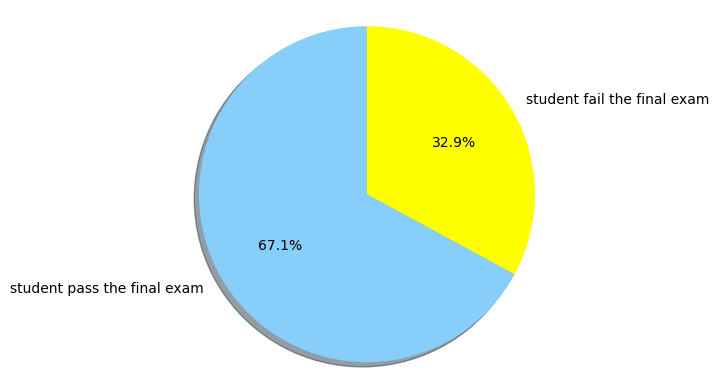

In [11]:
labels = 'student pass the final exam ', 'student fail the final exam'
sizes = [265, 130]
colors=['lightskyblue','yellow']
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

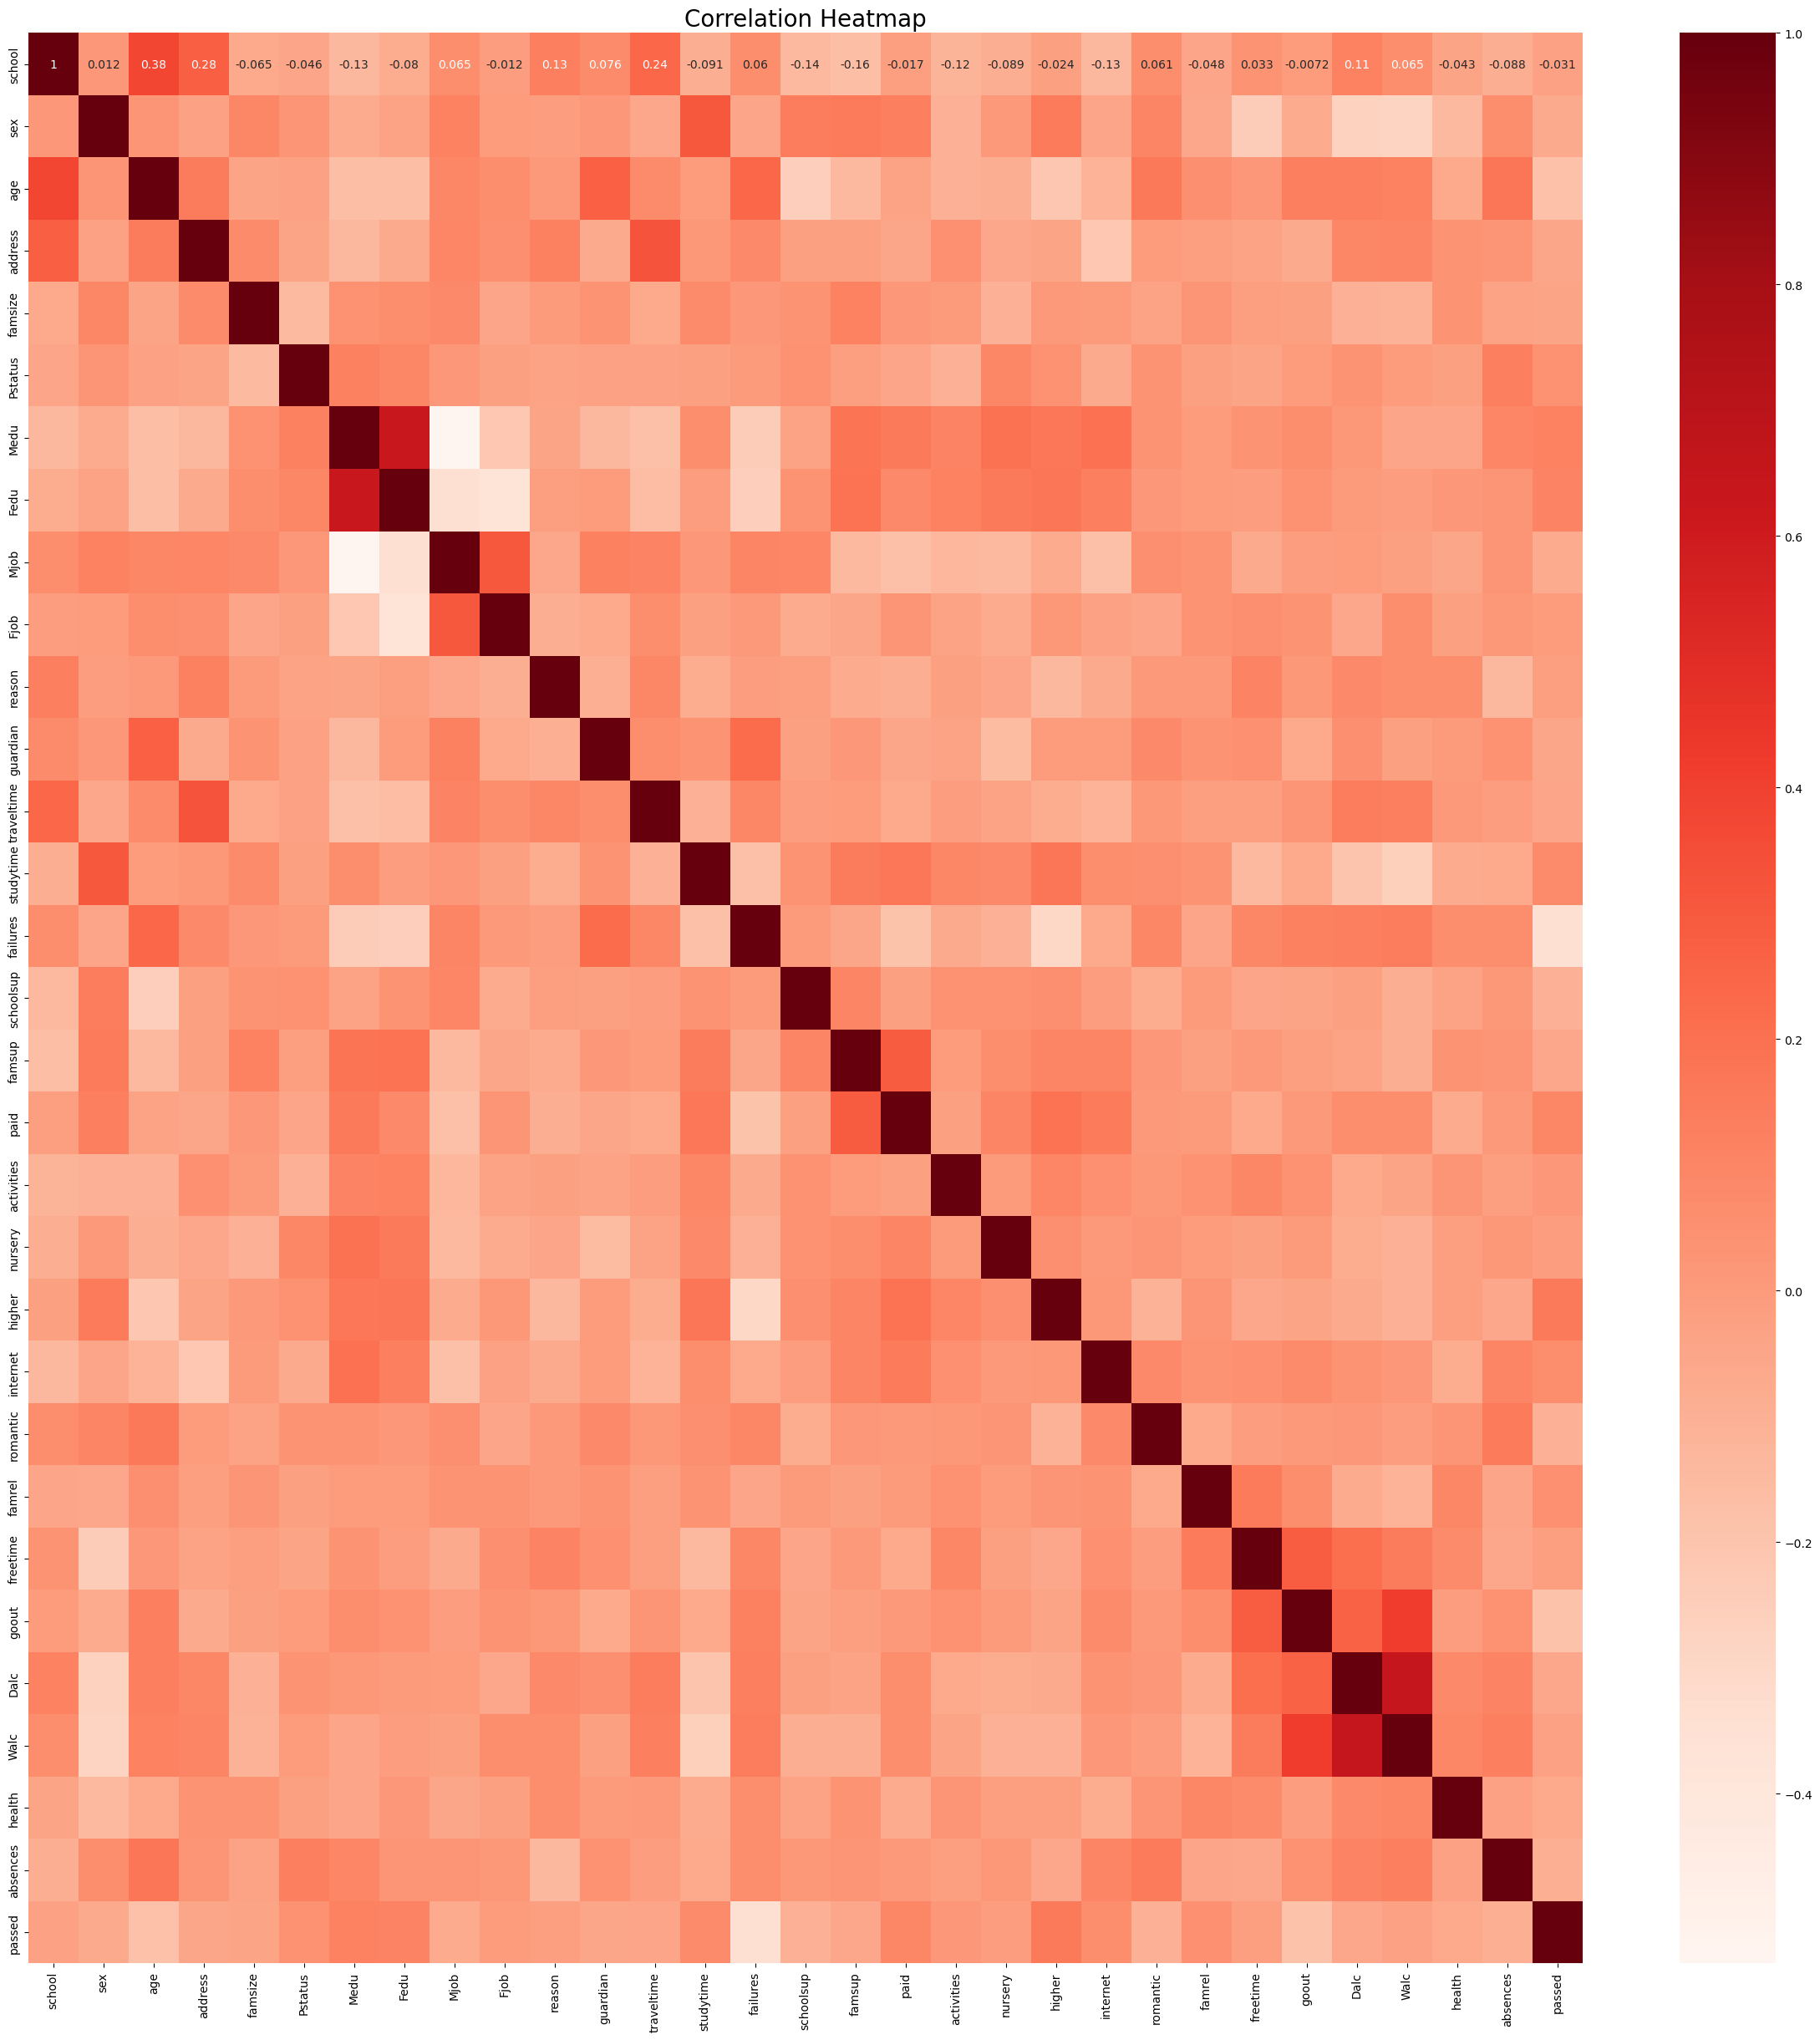

In [12]:
# see correlation between variables through a correlation heatmap
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title('Correlation Heatmap', fontsize=20)

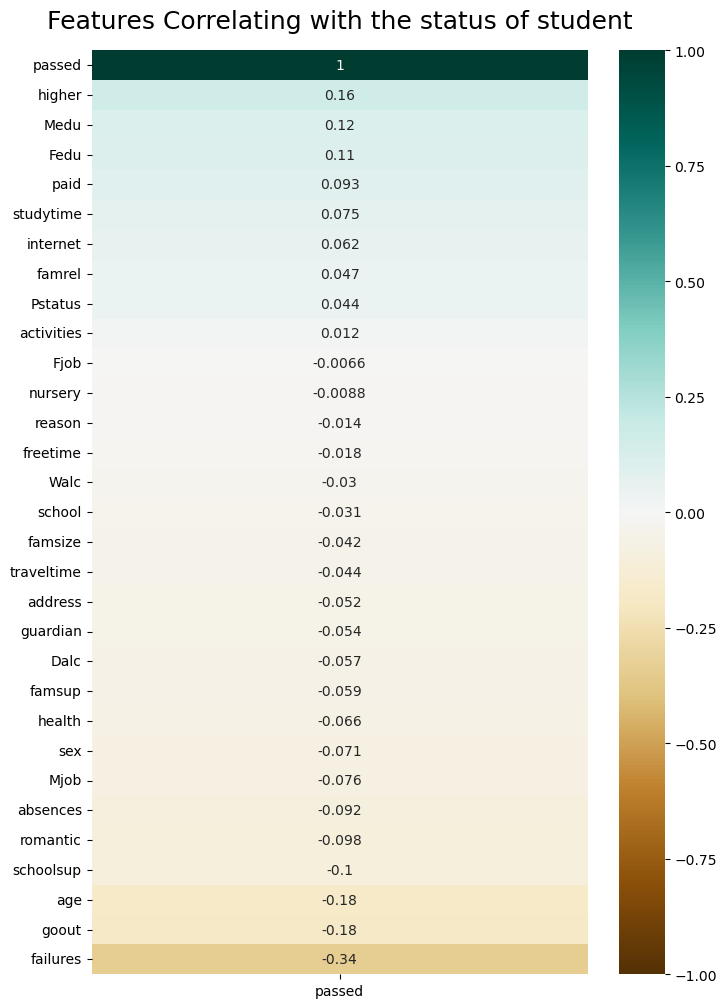

In [13]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['passed']].sort_values(by='passed', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the status of student', fontdict={'fontsize':18}, pad=16);

In [14]:
df["goout"].unique()

array([0.75, 0.5 , 0.25, 0.  , 1.  ])

Text(0.5, 0, 'Student status')

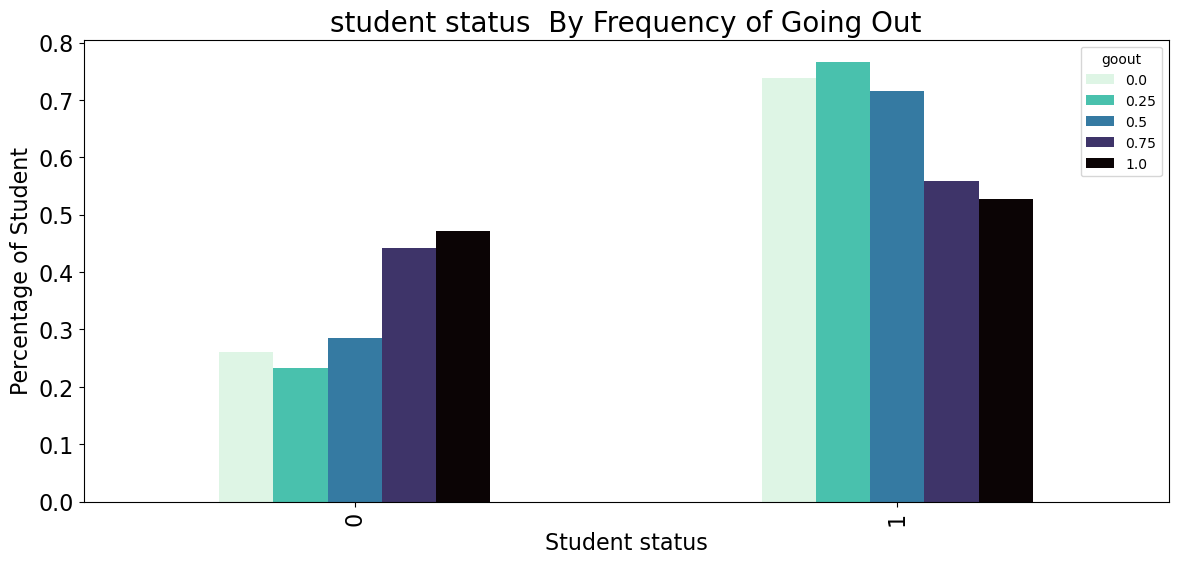

In [15]:
# going out
perc = (lambda col: col/col.sum())
index = [0,1]
out_tab = pd.crosstab(index=df.passed, columns=df.goout)
out_perc = out_tab.apply(perc).reindex(index)
out_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(14,6))
plt.title('student status  By Frequency of Going Out', fontsize=20)
plt.ylabel('Percentage of Student', fontsize=16)
plt.xlabel('Student status', fontsize=16)

<Figure size 640x480 with 0 Axes>

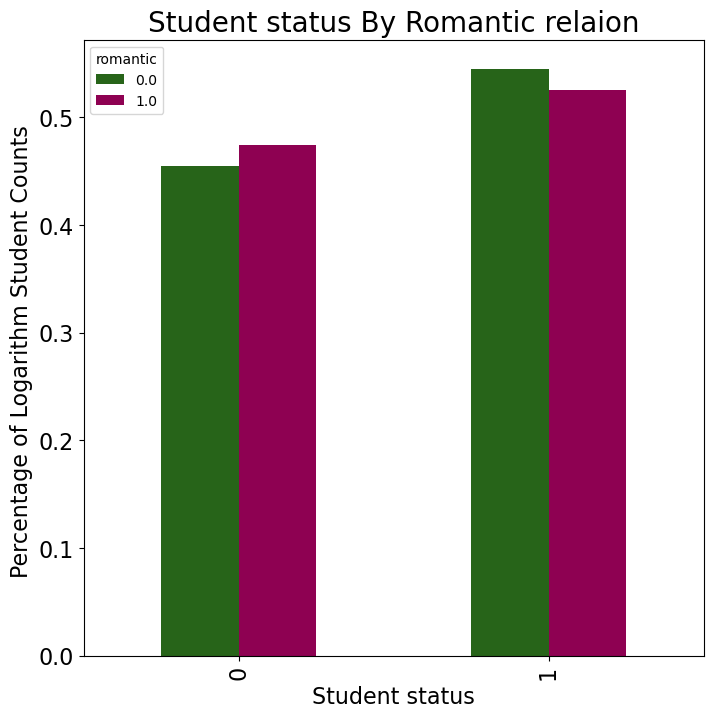

In [16]:
# romantic status
romance_tab1 = pd.crosstab(index=df.passed, columns=df.romantic)
romance_tab = np.log(romance_tab1)
romance_perc = romance_tab.apply(perc).reindex(index)
plt.figure()
romance_perc.plot.bar(colormap="PiYG_r", fontsize=16, figsize=(8,8))
plt.title('Student status By Romantic relaion', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
# 0 in romantic mean no romantic relation 

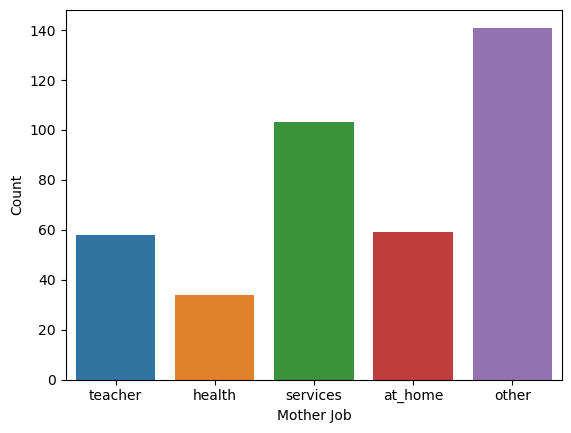

In [17]:
# 1) mother job 
# Mjob distribution
f, fx = plt.subplots()
figure = sns.countplot(x = 'Mjob', data=dfv, order=['teacher','health','services','at_home','other'])
fx = fx.set(ylabel="Count", xlabel="Mother Job")
figure.grid(False)

<Figure size 640x480 with 0 Axes>

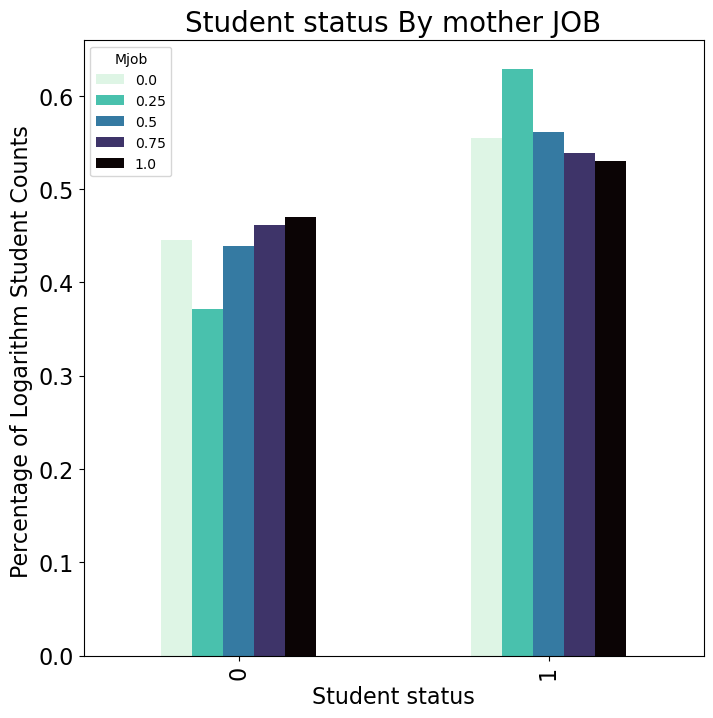

In [18]:
mjob_tab1 = pd.crosstab(index=df.passed, columns=df.Mjob)
mjob_tab = np.log(mjob_tab1)
mjob_perc = mjob_tab.apply(perc).reindex(index)
plt.figure()
mjob_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(8,8))
plt.title('Student status By mother JOB', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
#'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4

/tmp/ipykernel_5250/3018233835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_student_mother_education'] = good.Medu
/tmp/ipykernel_5250/3018233835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_student_mother_education'] = poor.Medu
/tmp/ipykernel_5250/3018233835.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p=sns.kdeplot(good['good_student_mother_education']

Text(0.5, 0, 'Mother Education Level')

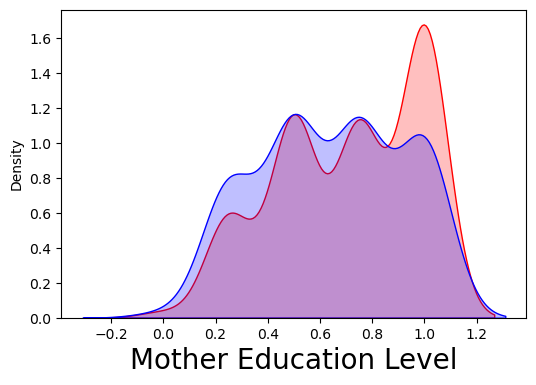

In [19]:
#Mother education:
good = df.loc[df.passed==1]
poor=df.loc[df.passed==0]
good['good_student_mother_education'] = good.Medu
poor['poor_student_mother_education'] = poor.Medu
plt.figure(figsize=(6,4))
p=sns.kdeplot(good['good_student_mother_education'], shade=True, color="r")#good_student in red
p=sns.kdeplot(poor['poor_student_mother_education'], shade=True, color="b")#poor_student in blue
plt.xlabel('Mother Education Level', fontsize=20)

Text(0, 0.5, 'Percentage of Student')

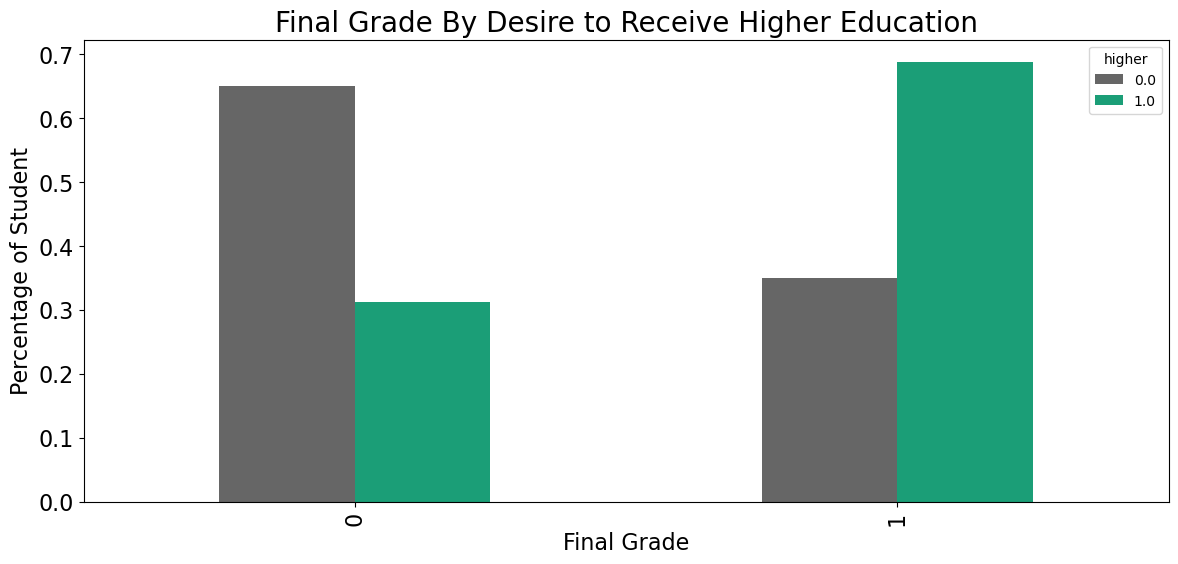

In [20]:
higher_tab = pd.crosstab(index=df.passed, columns=df.higher)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Final Grade By Desire to Receive Higher Education', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

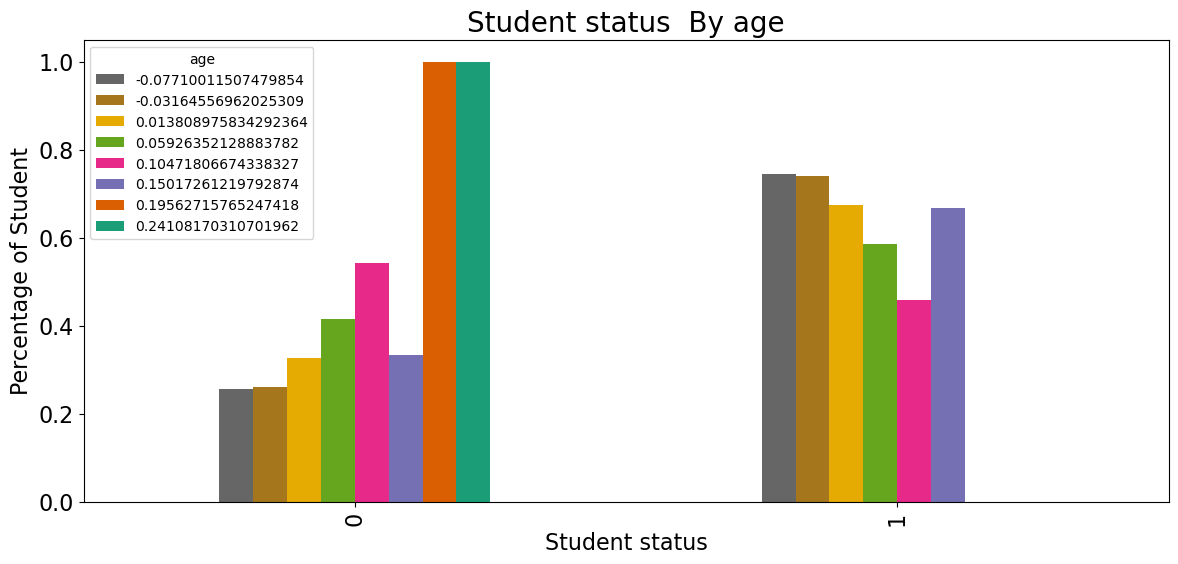

In [21]:
#impact of age
higher_tab = pd.crosstab(index=df.passed, columns=df.age)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Student status  By age', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

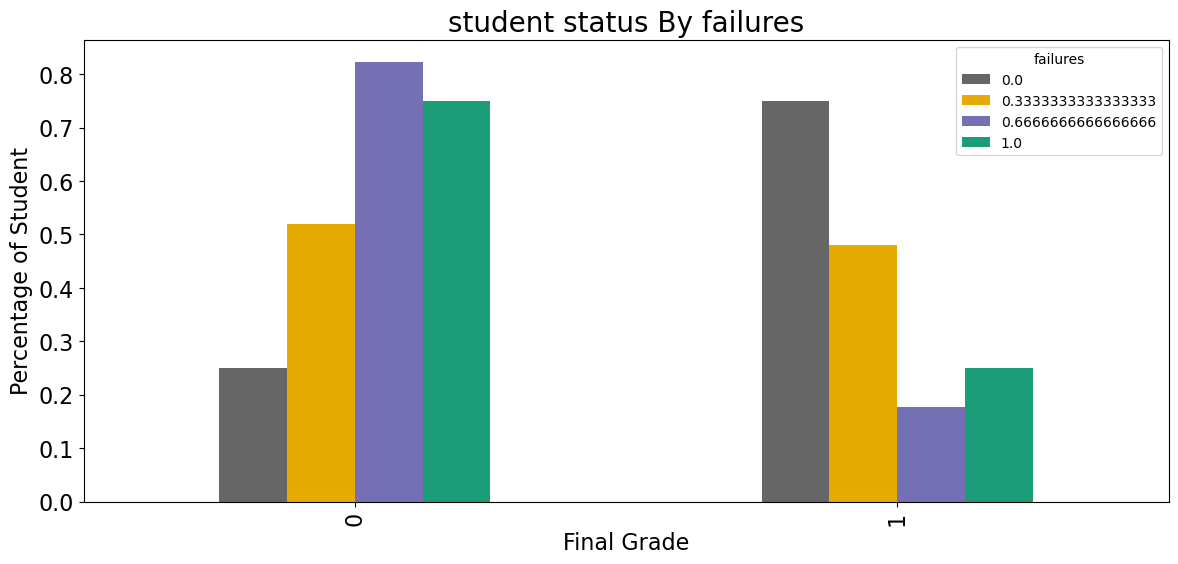

In [22]:
fail_tab = pd.crosstab(index=df.passed, columns=df.failures)
fail_perc = fail_tab.apply(perc).reindex(index)
fail_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By failures', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0.5, 1.0, 'Address Distribution')

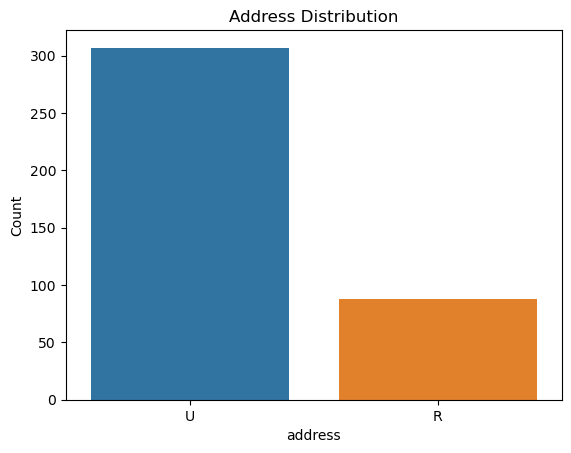

In [23]:
#first let's see the destribution of students who live in urban or rural area
f, fx = plt.subplots()
figure = sns.countplot(x = 'address', data=dfv, order=['U','R'])
fx = fx.set(ylabel="Count", xlabel="address")
figure.grid(False)
plt.title('Address Distribution')

Text(0.5, 0, 'Student status')

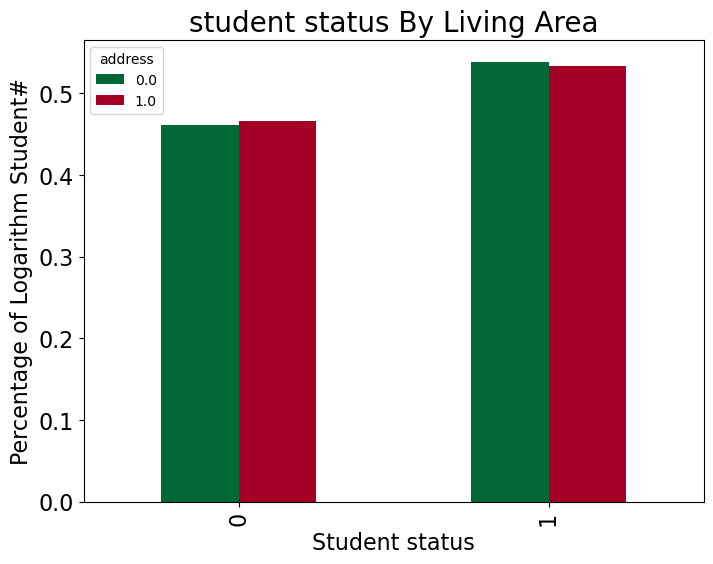

In [24]:
ad_tab1 = pd.crosstab(index=df.passed, columns=df.address)
ad_tab = np.log(ad_tab1)
ad_perc = ad_tab.apply(perc).reindex(index)
ad_perc.plot.bar(colormap="RdYlGn_r", fontsize=16, figsize=(8,6))
plt.title('student status By Living Area', fontsize=20)
plt.ylabel('Percentage of Logarithm Student#', fontsize=16)
plt.xlabel('Student status', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

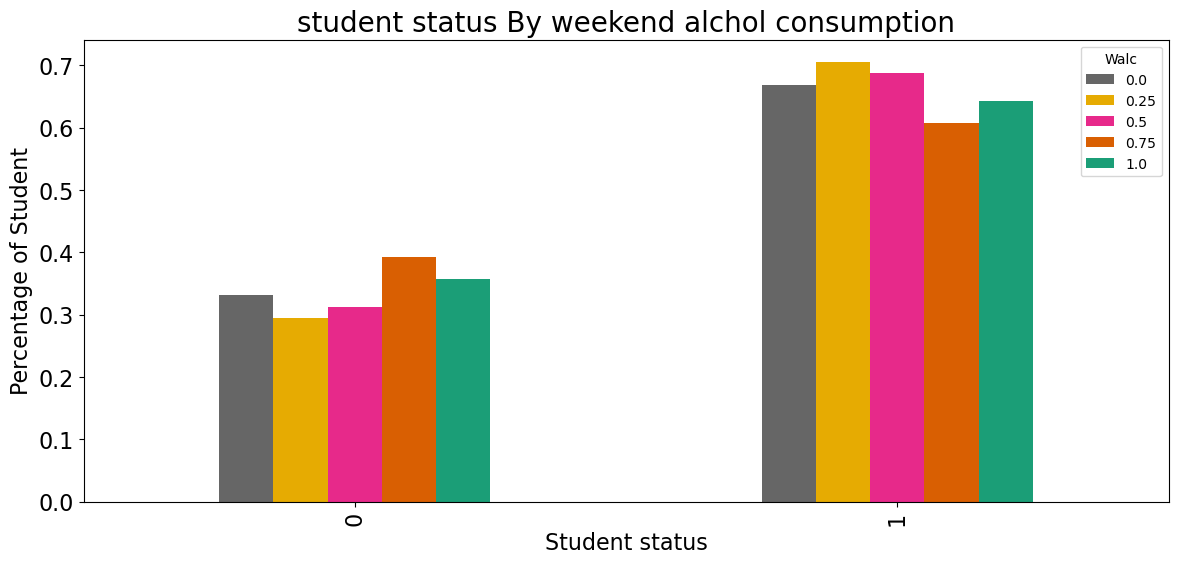

In [25]:
#impact of weekend alcohol consumption in student performance
alc_tab = pd.crosstab(index=df.passed, columns=df.Walc)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By weekend alchol consumption', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

/tmp/ipykernel_5250/1621555142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_alcohol_usage']=good.Walc
/tmp/ipykernel_5250/1621555142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_alcohol_usage']=poor.Walc
/tmp/ipykernel_5250/1621555142.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
/home/pavan

Text(0.5, 0, 'Level of Alcohol Consumption')

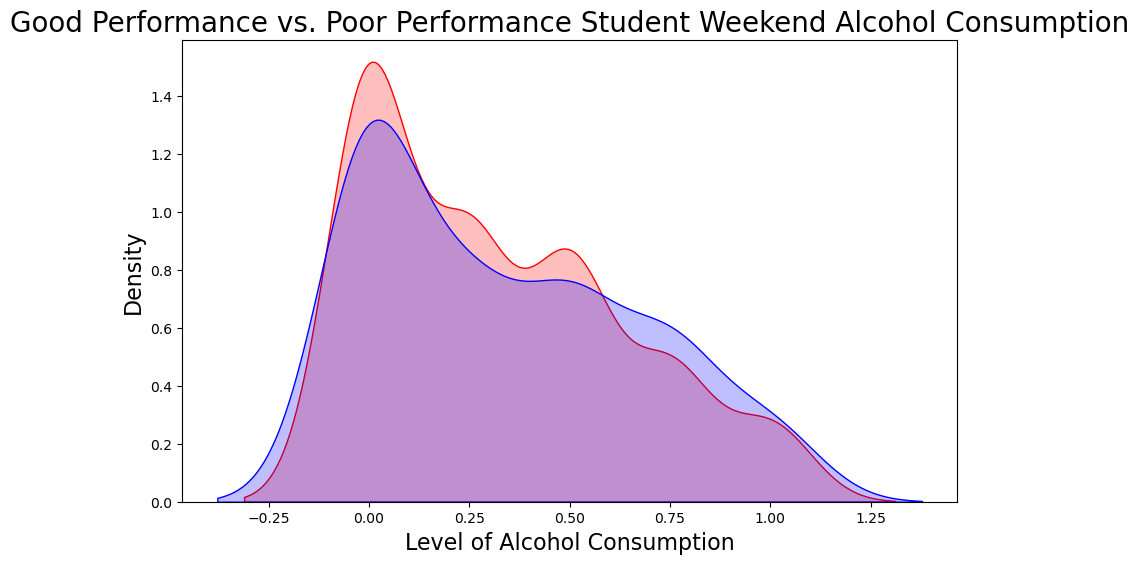

In [26]:
# weekend alcohol consumption
# create good student dataframe
good = df.loc[df.passed == 1]
good['good_alcohol_usage']=good.Walc
# create poor student dataframe
poor = df.loc[df.passed == 0]
poor['poor_alcohol_usage']=poor.Walc
plt.figure(figsize=(10,6))
p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
p1=sns.kdeplot(poor['poor_alcohol_usage'], shade=True, color="b")
plt.title('Good Performance vs. Poor Performance Student Weekend Alcohol Consumption', fontsize=20)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Level of Alcohol Consumption', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

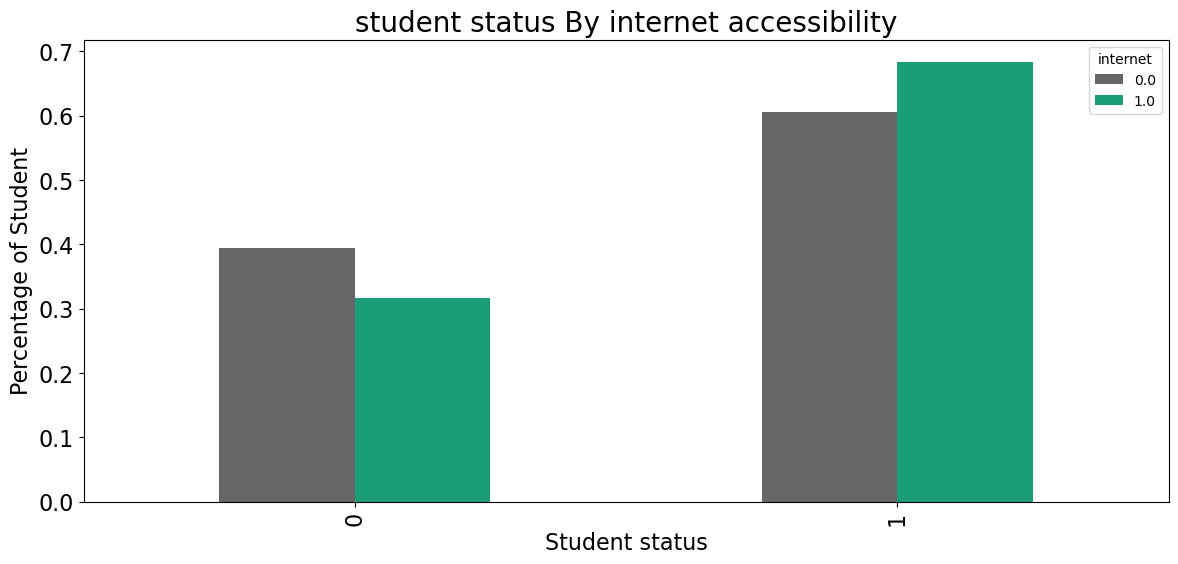

In [27]:
alc_tab = pd.crosstab(index=df.passed, columns=df.internet)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By internet accessibility', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

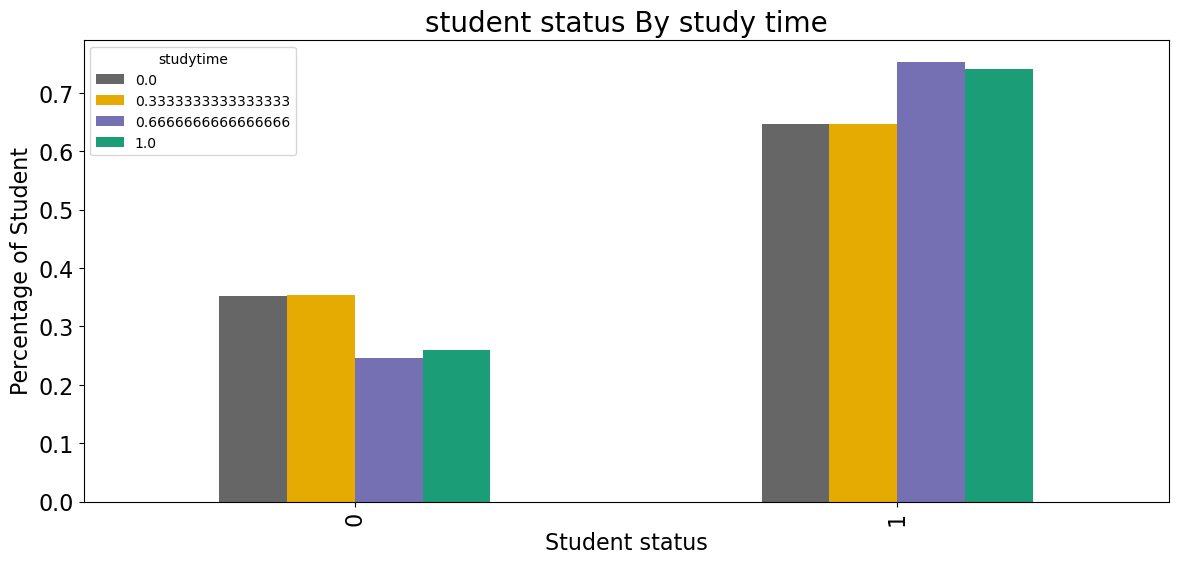

In [28]:
stu_tab = pd.crosstab(index=df.passed, columns=df.studytime)
stu_perc = stu_tab.apply(perc).reindex(index)
stu_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By study time', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

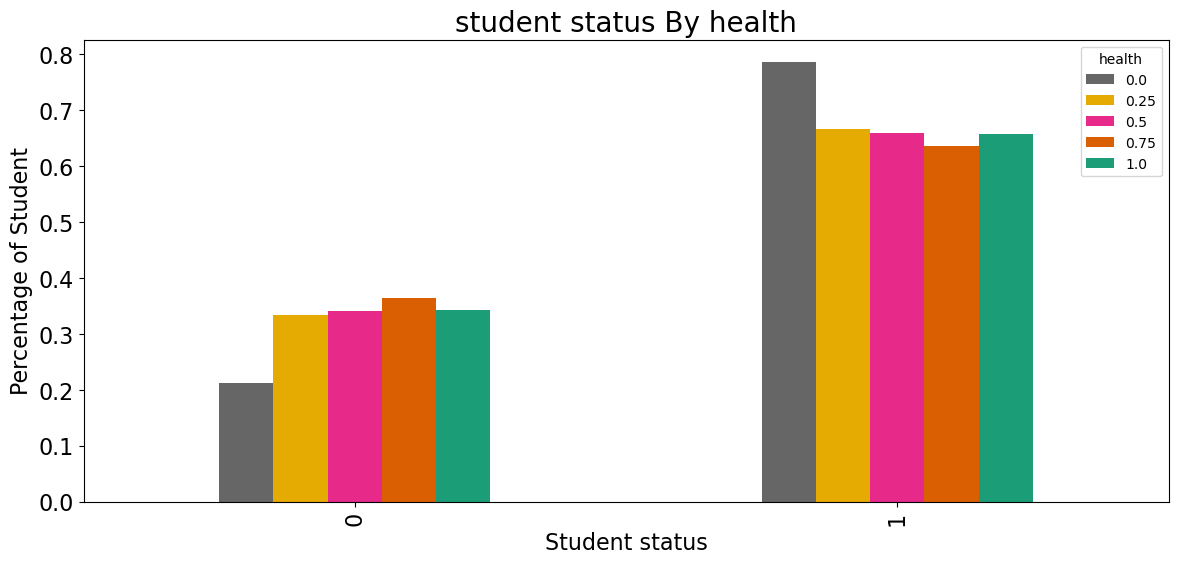

In [29]:
he_tab = pd.crosstab(index=df.passed, columns=df.health)
he_perc = he_tab.apply(perc).reindex(index)
he_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By health', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

In [30]:
#making summary for good condition to reach heigh academic potentials:

In [31]:
# split data train 70 % and test 30 %

data = df.to_numpy()
n = data.shape[1]
x = data[:,0:n-1]
y = data[:,n-1]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Once our data is split, we can forget about x_test and y_test until we define our model.
#x_train and y_train are the samples we will use to train the model

In [32]:
# let's create a model and train it 

logisticRegr = LogisticRegression(C=1)

In [33]:
#and now let's do the training

logisticRegr.fit(x_train,y_train)

LogisticRegression(C=1)

In [34]:
#The model is now trained and ready to make predictions :) 

In [35]:
y_pred=logisticRegr.predict(x_test)
y_pred


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In [36]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('#Accuracy test is: ',Sctest)
print('#Accuracy train is: ',Sctrain)


f1 = f1_score(y_test, y_pred, average='macro')

print('\n#f1 score is: ',f1)

#Accuracy test is:  0.6386554621848739
#Accuracy train is:  0.7463768115942029

#f1 score is:  0.5533734834598935


In [37]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('Accuracy test is: ',Sctest)
print('Accuracy train is: ',Sctrain)

Accuracy test is:  0.6386554621848739
Accuracy train is:  0.7463768115942029


In [38]:
#now, we can get the confusion matrix with confusion_matrix():

confusion_matrix(y_test, y_pred)

array([[12, 38],
       [ 5, 64]])

<Axes: >

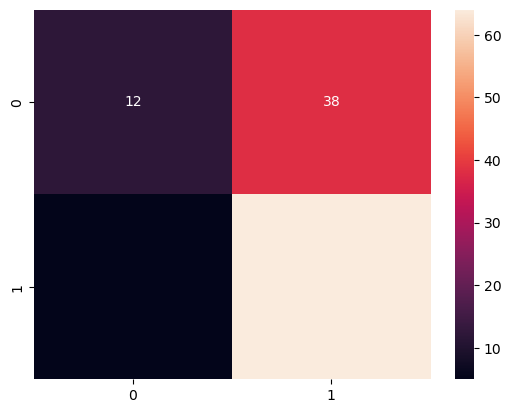

In [39]:
#let's visualize the confusion matrix:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

In [40]:
#import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.24      0.36        50
         1.0       0.63      0.93      0.75        69

    accuracy                           0.64       119
   macro avg       0.67      0.58      0.55       119
weighted avg       0.66      0.64      0.58       119



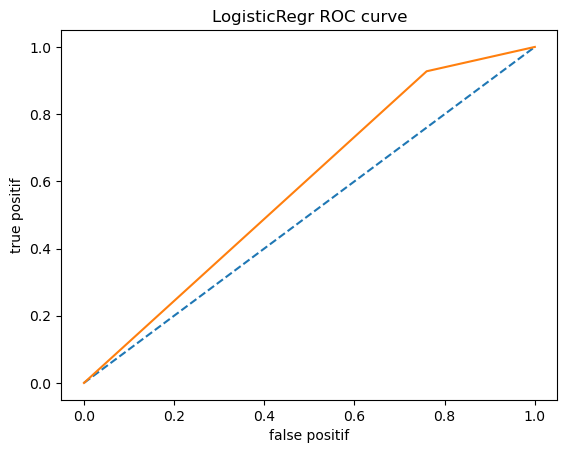

In [41]:
#ploting the roc_curve

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()




*Accuracy is: 80.67226890756302
*f1 score is:  0.7408389357068459


 *the ROC curve: 


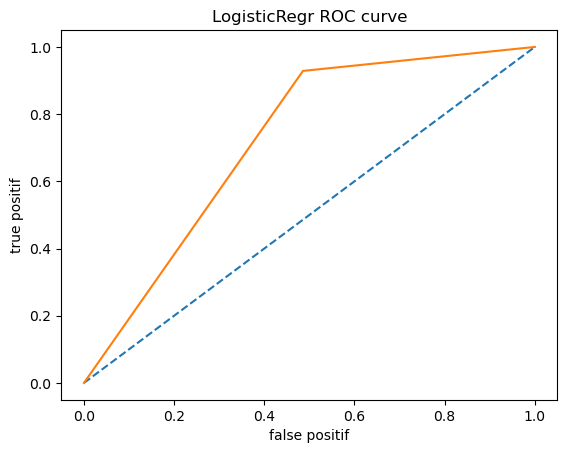

 *the confusion matrix 


<Axes: >

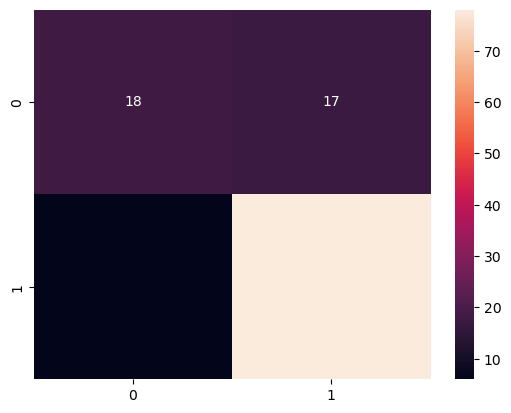

In [42]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
import random
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    logisticRegr = LogisticRegression(C=1)
    logisticRegr.fit(x_train,y_train)
    y_pred=logisticRegr.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
   
optimal_state = 85491961
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
logisticRegr = LogisticRegression(C=1)
logisticRegr.fit(x_train,y_train)
y_pred=logisticRegr.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

yt_lg,yp_lg = y_test,y_pred
#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()


#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)